In [115]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
import matplotlib

In [116]:
df = pd.read_csv("commonlitreadabilityprize/train.csv")
df = df.drop(columns=["url_legal", "license"])
print(df.shape)
df.head(10)

(2834, 4)


,id,excerpt,target,standard_error
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845
5,f9bf357fe,Hal and Chester found ample time to take an in...,-0.861809,0.480936
6,eaf8e7355,Hal Paine and Chester Crawford were typical Am...,-1.759061,0.476507
7,0a43a07f1,"On the twenty-second of February, 1916, an aut...",-0.952325,0.498116
8,f7eff7419,The boys left the capitol and made their way d...,-0.371641,0.463710
9,d96e6dbcd,One day he had gone beyond any point which he ...,-1.238432,0.465900


-3.676267773 1.711389827


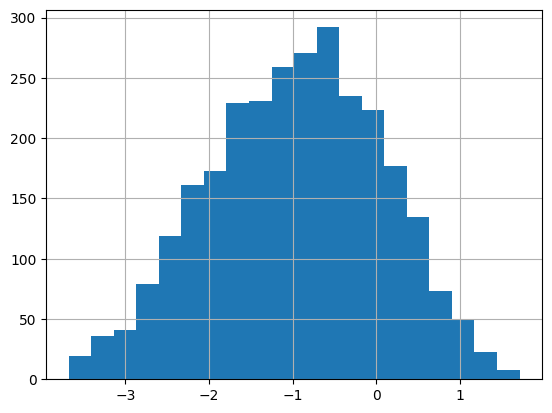

In [117]:
df["target"].hist(bins=20)
print(df["target"].min(), df["target"].max())

In [118]:
# added grade column based on excerpt
# use standard error to adjust scores with the confidence level

df['grade'] = pd.cut(df['target'], bins=[-2.35, -1.875, -1.53, -1.199, -1.192, -0.643, -0.466, -.136, .47 , .81, 1.71], labels=range(12, 2, -1))

In [119]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

@tf.keras.utils.register_keras_serializable()
class ReadabilityScoreLayer(Layer):
    def __init__(self, **kwargs):
        super(ReadabilityScoreLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Split text by spaces to estimate word count
        words = tf.strings.split(inputs)
        word_count = tf.map_fn(lambda x: tf.size(x), words, fn_output_signature=tf.int32)
        word_count = tf.cast(word_count, tf.float32)
        
        # Estimate sentence count by counting periods ('.')
        sentence_count = tf.strings.regex_replace(inputs, r"[^\.]", "")
        sentence_count = tf.strings.length(sentence_count)
        sentence_count = tf.cast(sentence_count, tf.float32)
        sentence_count = tf.maximum(sentence_count, 1.0)  # Avoid division by zero

        # Simplified readability score calculation
        readability_score = (0.39 * (word_count / sentence_count)) + (11.8 * (word_count / word_count)) - 15.59
        
        # Expand dimensions to match (batch_size, 1)
        return tf.expand_dims(readability_score, axis=-1)
    
    def compute_output_shape(self, input_shape):
        # Define the output shape (batch_size, 1)
        return (input_shape[0], 1)

In [120]:
# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [121]:
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model

# Define the inputs
text_input = Input(shape=(), dtype=tf.string, name="text_input")

# Text Vectorization and Embedding
vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=200)
vectorizer.adapt(df['excerpt'])  # Fit vectorizer on the text data
text_vectorized = vectorizer(text_input)
embedding = Embedding(input_dim=10000, output_dim=128)(text_vectorized)
pooled_text = GlobalAveragePooling1D()(embedding)

# Readability Score Calculation
readability_score = ReadabilityScoreLayer()(text_input)  # Calculates readability score internally

# Concatenate text features and readability score
concatenated = Concatenate()([pooled_text, readability_score])

# Define the dense layers for regression
dense1 = Dense(128, activation="relu")(concatenated)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation="relu")(dropout1)
dropout2 = Dropout(0.5)(dense2)

# Output layer
output = Dense(1, name="target_output")(dropout2)

# Define the model
model = Model(inputs=text_input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [122]:
# Assuming train_df has 'excerpt' and 'target' columns
train_texts = train_df['excerpt']
train_targets = train_df['target']

# Train the model using only the text input
history = model.fit(
    train_texts,
    train_targets,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.5105 - mae: 0.9385 - val_loss: 1.0193 - val_mae: 0.8120
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0575 - mae: 0.8089 - val_loss: 0.8018 - val_mae: 0.7354
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8209 - mae: 0.7095 - val_loss: 0.6241 - val_mae: 0.6440
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6652 - mae: 0.6399 - val_loss: 0.6713 - val_mae: 0.6676
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5288 - mae: 0.5730 - val_loss: 0.5694 - val_mae: 0.6071
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5010 - mae: 0.5472 - val_loss: 0.5687 - val_mae: 0.6087
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4264 - mae: 0.5085 - val_loss: 0.5252 - val_mae: 0.5776
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3528 - mae: 0.4536 - val_loss: 0.5029 - val_mae: 0.5608
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3360 - mae:

In [123]:
import textstat
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Load the test data
test_df = pd.read_csv("commonlitreadabilityprize/test copy.csv")
test_texts = test_df['excerpt']

# Predict without needing to compute readability scores manually
predictions = model.predict(test_texts)
test_df['predictions'] = predictions
test_df['grade'] = pd.cut(test_df['predictions'], bins=[-2.35, -1.875, -1.53, -1.199, -1.192, -0.643, -0.466, -.136, .47 , .81, 1.71], labels=range(12, 2, -1))

# Display predictions
print(test_df[['excerpt', 'predictions', 'grade']])

model.save("model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
                                             excerpt  predictions grade
0  Katie was six years old. She was part of a big...     0.582353     4
1  Emma was very excited. Today was the champions...     0.076189     5
2  Most babies’ first words are something like “D...    -0.741994     8
3  Juneteenth, celebrated on June 19th, is a sign...    -1.173740     8
4  Mary Boykin Miller Chesnut (1823-1886) was a p...    -0.104494     5
5  He told me what had happened to him and his co...     0.158957     5
6  Mine eye and heart are at a mortal war,\nHow t...    -1.764772    11
